In [1]:
%matplotlib inline
import time
import mxnet as mx
from mxnet import nd, nd as F, autograd as ag
from mxnet import gluon as gl
from mxnet.gluon import nn
import numpy as np
from matplotlib import pyplot as plt

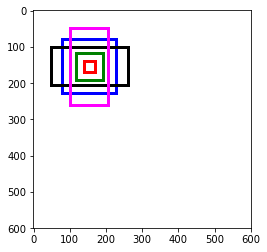

In [2]:
from mxnet.contrib.ndarray import MultiBoxPrior

m = 600
n = 80
x = nd.random.normal(0, 1, shape=(1, 3, n, n))
anchors = MultiBoxPrior(x, sizes=[0.5/2, 0.25/2, 0.1/2], ratios=[1, 2, 0.5])
anchors = anchors.reshape((n, n, -1, 4))


def box_to_rect(box, color, lw=3):
    box = box.asnumpy()
    return plt.Rectangle((box[0], box[1]), (box[2]-box[0]), (box[3]-box[1]), fill=False, edgecolor=color, linewidth=lw)

colors = ['blue', 'green', 'red', 'black', 'magenta']
plt.imshow(np.ones((m, m, 3)))
boxes = anchors[20, 20, :, :]
for i in range(len(boxes)):
    plt.gca().add_patch(box_to_rect(boxes[i]*m, colors[i]))
plt.show()

In [3]:
from mxnet.test_utils import download
import os.path as osp
def verified(file_path, sha1hash):
    import hashlib
    sha1 = hashlib.sha1()
    with open(file_path, 'rb') as f:
        while True:
            data = f.read(1048576)
            if not data:
                break
            sha1.update(data)
    matched = sha1.hexdigest() == sha1hash
    if not matched:
        print('Found hash mismatch in file {}, possibly due to incomplete download.'.format(file_path))
    return matched

url_format = 'https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/pikachu/{}'
hashes = {'train.rec': 'e6bcb6ffba1ac04ff8a9b1115e650af56ee969c8',
          'train.idx': 'dcf7318b2602c06428b9988470c731621716c393',
          'val.rec': 'd6c33f799b4d058e82f2cb5bd9a976f69d72d520'}
for k, v in hashes.items():
    fname = 'pikachu_' + k
    target = osp.join('data', fname)
    url = url_format.format(k)
    if not osp.exists(target) or not verified(target, v):
        print('Downloading', target, url)
        download(url, fname=fname, dirname='data', overwrite=True)

In [4]:
mx.random.seed(0)
np.random.seed(0)

data_shape = 256
batch_size = 32
def get_iterators(data_shape, batch_size):
    class_names = ['pikachu']
    num_class = len(class_names)
    train_iter = mx.image.ImageDetIter(
        batch_size=batch_size,
        data_shape=(3, data_shape, data_shape),
        path_imgrec='./data/pikachu_train.rec',
        path_imgidx='./data/pikachu_train.idx',
        shuffle=True,
        mean=True,
        rand_crop=1,
        min_object_covered=0.95,
        max_attempts=200)
    val_iter = mx.image.ImageDetIter(
        batch_size=batch_size,
        data_shape=(3, data_shape, data_shape),
        path_imgrec='./data/pikachu_val.rec',
        shuffle=False,
        mean=True)
    return train_iter, val_iter, class_names, num_class

train_data, val_data, class_names, num_class = get_iterators(data_shape, batch_size)
train_data.reshape(label_shape=(3, 5))
val_data.reshape(label_shape=(3, 5))


class FocalLoss(gl.loss.Loss):
    
    def __init__(self, axis=-1, alpha=0.25, gamma=2):
        super(FocalLoss, self).__init__(None, 0)
        self.axis = axis
        self.alpha = alpha
        self.gamma = gamma
        
    def hybrid_forward(self, F, x, label):
        x = F.softmax(x)
        p = F.pick(x, label)
        loss = -self.alpha * ((1 - p) ** self.gamma) * F.log(p)
        return F.mean(loss, axis=self._batch_axis, exclude=True)
    
class SmoothL1Loss(gl.loss.Loss):
    
    def __init__(self):
        super(SmoothL1Loss, self).__init__(None, 0)
        
    def hybrid_forward(self, F, x, label, mask):
        loss = F.smooth_l1((x - label) * mask, scalar=1)
        return F.mean(loss, axis=self._batch_axis, exclude=True)

class SSDLoss(gl.loss.Loss):
    
    def __init__(self, alpha=1):
        super(SSDLoss, self).__init__(None, 0)
        self.alpha = alpha
        self.cls_loss = FocalLoss()
        self.box_loss = SmoothL1Loss()
        
    def hybrid_forward(self, F, anchors, pred_cls, pred_box, label):
        pred_cls_trans = F.transpose(pred_cls, axes=(0, 2, 1))
        box_target, box_mask, cls_target = F.contrib.MultiBoxTarget(anchors, label, pred_cls_trans)
        loss1 = self.cls_loss(pred_cls, cls_target)
        loss2 = self.box_loss(pred_box, box_target, box_mask)
        loss = loss1 + self.alpha * loss2
        return box_target, box_mask, cls_target, loss
    

class ToySSD(nn.HybridBlock):
    
    def __init__(self, use_fpn=False):
        super(ToySSD, self).__init__()
        self.use_fpn = use_fpn
        #self.anchor_sizes = [[.2, .272], [.37, .447], [.54, .619], [.71, .79]]
        self.anchor_sizes = [[.1, .2], [.3, .4], [.5, .6], [.7, .8]]
        self.anchor_ratios = [[1, 2, .5]] * 4
        with self.name_scope():
            self.body_net = self.backbone()
            self.down_sample_layers = nn.HybridSequential()
            self.fpn_trans1_layers = nn.HybridSequential()
            self.fpn_trans2_layers = nn.HybridSequential()
            self.cls_pred_layers = nn.HybridSequential()
            self.box_pred_layers = nn.HybridSequential()
            for i in range(3):
                self.down_sample_layers.add(self.down_sample(128))
            if self.use_fpn:
                for i in range(4):
                    self.fpn_trans1_layers.add(self.conv_bn_relu(128, 1, 1, 0))
                for i in range(3):
                    self.fpn_trans2_layers.add(self.conv_bn_relu(128, 3, 1, 1))
            for i in range(4):
                self.cls_pred_layers.add(self.cls_predictor(4, 2))
                self.box_pred_layers.add(self.box_predictor(4))
            
    def hybrid_forward(self, F, x):
        x = self.body_net(x)
        pred_anchors = []
        pred_cls = []
        pred_box = []
        # feature pyramid
        f1 = x # 128x32x32
        f2 = self.down_sample_layers[0](f1) # 128x16x16
        f3 = self.down_sample_layers[1](f2) # 128x8x8
        f4 = self.down_sample_layers[2](f3) # 128x4x4
        if self.use_fpn:
            f4 = self.fpn_trans1_layers[3](f4)
            f3 = self.fpn_trans1_layers[2](f3) + F.UpSampling(f4, scale=2, sample_type='nearest')
            f2 = self.fpn_trans1_layers[1](f2) + F.UpSampling(f3, scale=2, sample_type='nearest')
            f1 = self.fpn_trans1_layers[0](f1) + F.UpSampling(f2, scale=2, sample_type='nearest')
            f1 = self.fpn_trans2_layers[0](f1)
            f2 = self.fpn_trans2_layers[1](f2)
            f3 = self.fpn_trans2_layers[2](f3)
        feat = [f1, f2, f3, f4]
        # output
        for i in range(4):
            pred_anchors.append(F.contrib.MultiBoxPrior(feat[i], sizes=self.anchor_sizes[i], ratios=self.anchor_ratios[i]))
            pred_cls.append(F.reshape(F.flatten(F.transpose(self.cls_pred_layers[i](feat[i]), axes=(0, 2, 3, 1))), shape=(0, -1, 2)))
            pred_box.append(F.flatten(F.transpose(self.box_pred_layers[i](feat[i]), axes=(0, 2, 3, 1))))
        pred_anchors = F.concat(*pred_anchors, dim=1)
        pred_cls = F.concat(*pred_cls, dim=1)
        pred_box = F.concat(*pred_box, dim=1)
        return pred_anchors, pred_cls, pred_box

    def cls_predictor(self, num_anchors, num_cls):
        return nn.Conv2D(num_anchors * num_cls, 3, 1, 1)
    
    def box_predictor(self, num_anchors):
        return nn.Conv2D(num_anchors * 4, 3, 1, 1)
    
    def backbone(self):
        block = nn.HybridSequential()
        for nfilters in [16, 32, 64]:
            block.add(self.down_sample(nfilters))
        return block

    def conv_bn_relu(self, num_filters, kernel=3, stride=1, padding=0):
        cbr = nn.HybridSequential()
        cbr.add(nn.Conv2D(num_filters, kernel, stride, padding))
        cbr.add(nn.BatchNorm())
        cbr.add(nn.Activation(activation='relu'))
        return cbr
    
    def down_sample(self, num_filters):
        block = nn.HybridSequential()
        block.add(self.conv_bn_relu(num_filters, 3, 1, 1))
        block.add(self.conv_bn_relu(num_filters, 3, 1, 1))
        block.add(nn.MaxPool2D(2, 2))
        return block
    

def train_net(use_fpn=True):
    net = ToySSD(use_fpn=use_fpn)
    ctx = mx.gpu()
    net.initialize(mx.init.Normal(), ctx=ctx)
    net.hybridize()
    trainer = gl.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1, 'momentum': 0.9, 'wd': 1e-4})

    ssd_loss = SSDLoss()
    cls_metric = mx.metric.Accuracy(axis=2)
    box_metric = mx.metric.MAE()

    start_epoch = 0
    epoches = 10
    for epoch in range(start_epoch, epoches):
        train_data.reset()
        val_data.reset()
        cls_metric.reset()
        box_metric.reset()
        tic = time.time()
        for i, batch in enumerate(train_data):
            with ag.record():
                x = batch.data[0].as_in_context(ctx)
                y = batch.label[0].as_in_context(ctx)
                anchors, pred_cls, pred_box = net(x)
                box_target, box_mask, cls_target, loss = ssd_loss(anchors, pred_cls, pred_box, y)
            loss.backward()
            trainer.step(x.shape[0])
            print('batch %d, loss: %f'%(i+1, loss.mean().asscalar()))
            cls_metric.update([cls_target], [pred_cls])
            box_metric.update([box_target], [pred_box * box_mask])
        toc = time.time()
        print('[train] Epoch %d, cls: %f, box: %f, time cost %f s' % (epoch+1, cls_metric.get()[1], box_metric.get()[1], toc-tic))
        cls_metric.reset()
        box_metric.reset()
        total_loss = []
        tic = time.time()
        for i, batch in enumerate(val_data):
            x = batch.data[0].as_in_context(ctx)
            y = batch.label[0].as_in_context(ctx)
            anchors, pred_cls, pred_box = net(x)
            box_target, box_mask, cls_target, loss = ssd_loss(anchors, pred_cls, pred_box, y)
            cls_metric.update([cls_target], [pred_cls])
            box_metric.update([box_target], [pred_box * box_mask])
            total_loss.append(loss.mean().asscalar())
        toc = time.time()
        print('[test]  Epoch %d, cls: %f, box: %f, loss: %f, time cost %f s' % (epoch+1, cls_metric.get()[1], box_metric.get()[1], np.mean(total_loss), toc-tic))
        if use_fpn:
            net.save_params('./tmp/pikachu-fpn-%03d.params'%(epoch+1))
        else:
            net.save_params('./tmp/pikachu-%03d.params'%(epoch+1))

print('use fpn: False')
train_net(use_fpn=False)
print('use fpn: True')
train_net(use_fpn=True)

use fpn: False
batch 1, loss: 0.044801
batch 2, loss: 0.018549
batch 3, loss: 0.007830
batch 4, loss: 0.004490
batch 5, loss: 0.003487
batch 6, loss: 0.003283
batch 7, loss: 0.002654
batch 8, loss: 0.002331
batch 9, loss: 0.002526
batch 10, loss: 0.002365
batch 11, loss: 0.002145
batch 12, loss: 0.002045
batch 13, loss: 0.001543
batch 14, loss: 0.001988
batch 15, loss: 0.001834
batch 16, loss: 0.001683
batch 17, loss: 0.002566
batch 18, loss: 0.001320
batch 19, loss: 0.001791
batch 20, loss: 0.001845
batch 21, loss: 0.001489
batch 22, loss: 0.002497
batch 23, loss: 0.001667
batch 24, loss: 0.001574
batch 25, loss: 0.001691
batch 26, loss: 0.001629
batch 27, loss: 0.001420
batch 28, loss: 0.001417
batch 29, loss: 0.001162
[train] Epoch 1, cls: 0.980792, box: 0.001580, time cost 29.669000 s
[test]  Epoch 1, cls: 0.999344, box: 0.000754, loss: 0.001965, time cost 1.494000 s
batch 1, loss: 0.001794
batch 2, loss: 0.001386
batch 3, loss: 0.001610
batch 4, loss: 0.001454
batch 5, loss: 0.001

use fpn: False

[[[ 0.          0.51685238  0.52084929  0.50453097  0.67658025  0.71650177]
  [-1.          0.50522327  0.52204007  0.50276268  0.68139797  0.71428859]
  [ 0.          0.46737263  0.74175441  0.51980001  0.89479756  0.72688824]
  ..., 
  [-1.         -1.         -1.         -1.         -1.         -1.        ]
  [-1.         -1.         -1.         -1.         -1.         -1.        ]
  [-1.         -1.         -1.         -1.         -1.         -1.        ]]]
<NDArray 1x5440x6 @gpu(0)>


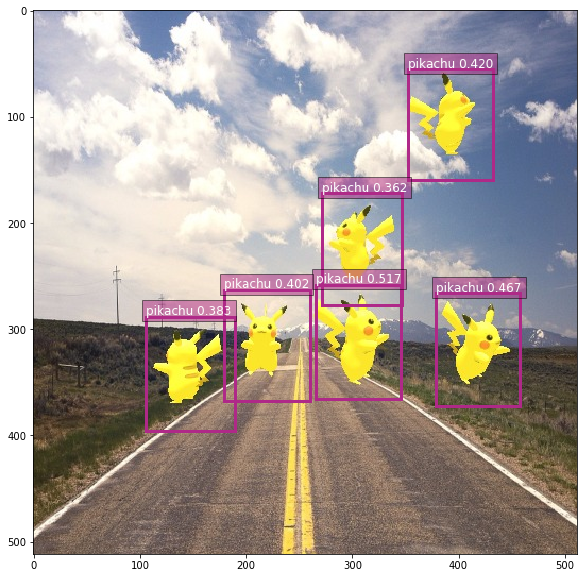

use fpn: True

[[[ 0.          0.53330481  0.51259321  0.5166496   0.65848976  0.69957447]
  [-1.          0.49581078  0.52134579  0.51719165  0.66414958  0.69739592]
  [ 0.          0.47613558  0.69280529  0.10976236  0.83112729  0.29098201]
  ..., 
  [-1.         -1.         -1.         -1.         -1.         -1.        ]
  [-1.         -1.         -1.         -1.         -1.         -1.        ]
  [-1.         -1.         -1.         -1.         -1.         -1.        ]]]
<NDArray 1x5440x6 @gpu(0)>


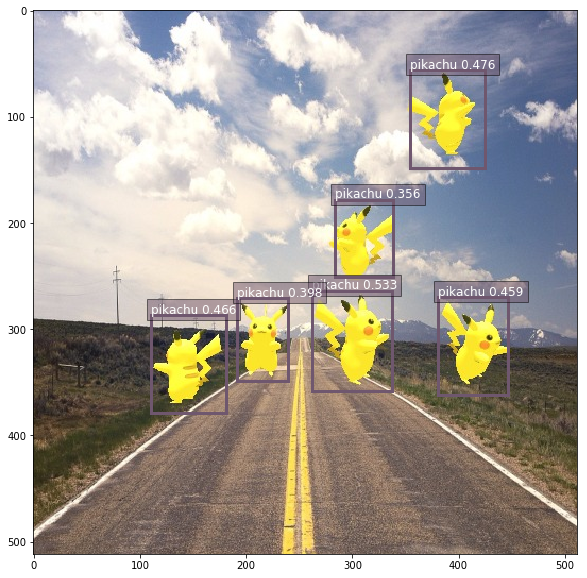

In [6]:
import numpy as np
import cv2
def preprocess(image):
    """Takes an image and apply preprocess"""
    # resize to data_shape
    image = cv2.resize(image, (data_shape, data_shape))
    # swap BGR to RGB
    image = image[:, :, (2, 1, 0)]
    # convert to float before subtracting mean
    image = image.astype(np.float32)
    # subtract mean
    image -= np.array([123, 117, 104])
    # organize as [batch-channel-height-width]
    image = np.transpose(image, (2, 0, 1))
    image = image[np.newaxis, :]
    # convert to ndarray
    image = nd.array(image)
    return image

image = cv2.imread('pikachu.jpg')
#image = image[:, ::-1, :]
x = preprocess(image)
#print('x', x.shape)

def test_net(use_fpn=False, test_epoch=10):
    net = ToySSD(use_fpn=use_fpn)
    net.hybridize()
    ctx = mx.gpu()
    if use_fpn:
        net.load_params('./tmp/pikachu-fpn-%03d.params'%test_epoch, ctx)
    else:
        net.load_params('./tmp/pikachu-%03d.params'%test_epoch, ctx)

    anchors, cls_preds, box_preds = net(x.as_in_context(ctx))
    # print('anchors', anchors)
    # print('class predictions', cls_preds)
    # print('box delta predictions', box_preds)

    from mxnet.contrib.ndarray import MultiBoxDetection
    # convert predictions to probabilities using softmax
    cls_probs = nd.SoftmaxActivation(nd.transpose(cls_preds, (0, 2, 1)), mode='channel')
    # apply shifts to anchors boxes, non-maximum-suppression, etc...
    output = MultiBoxDetection(*[cls_probs, box_preds, anchors], force_suppress=True, clip=False)
    return output

def display(img, out, thresh=0.5):
    import random
    import matplotlib as mpl
    mpl.rcParams['figure.figsize'] = (10,10)
    pens = dict()
    plt.clf()
    plt.imshow(img)
    for det in out:
        cid = int(det[0])
        if cid < 0:
            continue
        score = det[1]
        #print(cid, score)
        if score < thresh:
            continue
        if cid not in pens:
            pens[cid] = (random.random(), random.random(), random.random())
        scales = [img.shape[1], img.shape[0]] * 2
        xmin, ymin, xmax, ymax = [int(p * s) for p, s in zip(det[2:6].tolist(), scales)]
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False,
                             edgecolor=pens[cid], linewidth=3)
        plt.gca().add_patch(rect)
        text = class_names[cid]
        plt.gca().text(xmin, ymin-2, '{:s} {:.3f}'.format(text, score),
                       bbox=dict(facecolor=pens[cid], alpha=0.5),
                       fontsize=12, color='white')
    plt.show()

print('use fpn: False')
output = test_net(use_fpn=False, test_epoch=10)
print(output)
display(image[:, :, (2, 1, 0)], output[0].asnumpy(), thresh=0.35)
print('use fpn: True')
output = test_net(use_fpn=True, test_epoch=10)
print(output)
display(image[:, :, (2, 1, 0)], output[0].asnumpy(), thresh=0.35)